<a href="https://colab.research.google.com/github/fipaniagua/IIC3697-Deep-Learning/blob/develop/LSTM%20RNN%20and%20attention%20with%20Pytorch/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2: Redes Neuronales Recurrentes (RNNs)

Francisco Paniagua


## Actividad 1


En primer lugar Implementamos el modelo RNN *many-to-one*

In [0]:
import torch
import torch.nn as nn

In [0]:
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers):
    super().__init__() 
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers 
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
    self.linear_out = nn.Linear(hidden_dim, 1)
  
  # This method defines the forward pass of the RNN 
  def forward(self, input):
    batch_size, _ = input.size()
    # Initializing hidden state for first input 
    h0 = self.init_hidden(batch_size) 
    # Passing in the input and hidden state to obtain output 
    _, hidden_state = self.rnn(input.unsqueeze(2), h0) 
    out = self.linear_out(hidden_state.squeeze())
    return out

  # This method generates the first hidden state of zeros for the forward pass 
  # This creates a tensor of zeros in the shape of our hidden states. 
  def init_hidden(self, batch_size): 
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    return hidden

Podemos notar que la cantidad de parametros de nuestro modelo RNN depende de tres hiper parametros principales:


1.   Input dimension
2.   Hidden dimension
3.   Number of layers

Debido a esto si fijamos la deminsión interna a 100 y solo una capa oculta, el unico parametro que podemos varias es `la dimensión de entrada`. Como la dimension de entrada depende del **embeding** y este a su vez depende del **vocabulario** podemos argumentar que dependiendo del dataset podria cambiar la cantidad de parametros necesarios.

Ahora bien, el embeding no solo depende del vocabulario sino tambien depende de la desición de con cuanta información nos queremos quedar para representar nuestro input. Esto genera un *trade-off* entre la cantidad de parametros y la cantidad de información que queremos "guardar".  

A continuación un grafico que muestra esta relación (con modelos de capa oculta de una dimension de 100 y otro de 50).



In [0]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
posible_input_dimensions = [10**i for i in range(1,7)]
num_parameters_100 = []
num_parameters_50 = []
for input_dimension in posible_input_dimensions:
  parameters_100 = num_trainable_parameters(RNN(input_dimension, 100, 1))
  parameters_50 = num_trainable_parameters(RNN(input_dimension, 50, 1))
  num_parameters_100.append(parameters_100)
  num_parameters_50.append(parameters_50)
  print("{0} | {1} | {2} | {3}".format(
      input_dimension,
      parameters_50,
      parameters_100,
      parameters_100/parameters_50
  ))

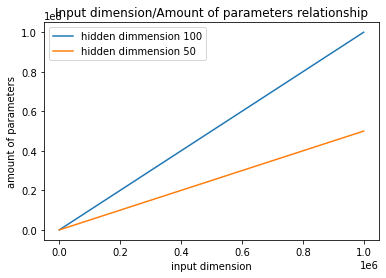

In [19]:
import matplotlib.pyplot as plt

plt.plot(posible_input_dimensions, num_parameters_100)
plt.plot(posible_input_dimensions, num_parameters_50)
plt.title("Input dimension/Amount of parameters relationship")
plt.xlabel("input dimension")
plt.ylabel("amount of parameters")
plt.legend(["hidden dimmension 100", "hidden dimmension 50"], loc='upper left')
plt.show()

dimension de entrada | cantidad de parametros (capa interna 50) | cantidad de parametros (capa interna 100) | relación entre modelo de capa interna 50 y 100
--- | --- | --- | --- |  
10 | 3151 | 11301 | 3.586480482386544
100 | 7651 | 20301 | 2.6533786433145994
1000 | 52651 | 110301 | 2.0949459649389377
10000 | 502651 | 1010301 | 2.0099452701775187
100000 | 5002651 | 10010301 | 2.000999270186947
1000000 | 50002651 | 100010301 | 2.0000999746993413

Es claro en el grafico que existe una relación lineal entre la cantidad de parametros y la dimensión de entrada. Ademas al disminuir a 50 la dimension interna, la cantidad de parametros tiende a disminuir a la mitad a medida que aumentamos la dimension de entrada.

Podemos confirmar esta relación teoricamente tambien. La cantidad de parametros puede ser calculada de la siguiente forma:

\begin{align}
parametros_{totales} & = Parametros_{Rnn Cell} + Parametros_{Capa final}\\
parametros_{totales} & = \{\#(W_{ih}) + \#(b_{ih}) + \#(W_{hh}) + \#(b_{hh})\} + \{\#(W_{h1}) + \#(b_{1}) \}  \\
parametros_{totales} & = (h*i + h + h*h + h) + (h*1 + 1)\\
parametros_{totales} & = h(i+ h + 3) +1 \\
parametros_{totales} & = h^2 + 3h + h*i + 1
\end{align} 



Interesantemente, a pesar de que la cantidad de parametros aumenta cuadraticamente en relación a la dimensión interna. Si calculamos el limite cuando la dimension del input i tiende a infinito, El aumento porcentual de los parametros tiende a dos cuando duplicamos la dimensión interna (lo cual coincide con nuestros resultados empiricos):

\begin{align}
\lim_{i \to \infty} (4h^2+6h+2hi+1)/(h^2+3h+hi+1) = 2.
\end{align} 

Es decir, mientras mas grande es la dimension de la entrada, mas liniealmente se comporta el aumento de parametros en razón del aumento de la dimensión interna
